# Topic Modeling with Latent Dirichlet Allocation

> -  In this Part, we will work mainly with review data, and trying to model what are passenger not happy about their flight. Therefore, we will implemented topic modeling using Latent Dirichlet Allocation for only the negative review segment of an airline.

In [57]:
import pandas as pd
from textblob import TextBlob 
import contractions
import numpy as np
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [2]:

# Function to return review a a specific airline

def load_review_data(Airline= None):
    # a pickle file of dataframe has been created in advance for better loading time compared to loading from xlsx file.
    reviews_data = pd.read_pickle('Airline_Review_Data/all_reviews')
    if Airline == None:
        return reviews_data['airline'].unique()
    else: 
        df = reviews_data.loc[reviews_data['airline'] == Airline]
        df['customer_review'] = df['customer_review'].str.replace('-', '_',regex=True)
        return df

In [3]:
df = load_review_data('Lufthansa')


def polarity(text: str) -> 'Create a function to get the polarity':
    #expanding contraction in text
    expand_text = contractions.fix(text)
    # remove non-ascii character in text
    ascii_text = ("".join(c for c in expand_text if ord(c)<128))
    return TextBlob(ascii_text).sentiment.polarity

df['Polarity'] = df['customer_review'].apply(polarity)
#filter out only negative reviews
df_neg = df.loc[(df['Polarity'] <=0)]

corpus = df_neg['customer_review'].tolist()

# Preprocessing text data

In [17]:
from gensim.utils import simple_preprocess 
from nltk.corpus import stopwords

# tokennizing, lowecassing, pucntualtion removing, 
#accent mark removing, number removing, stop-words removing
#Created unigram corpus
stop_words = stopwords.words('english')
unigram_copus=[]
for text in corpus:
    unigram_copus.append([word for word in simple_preprocess(text, min_len =3) if word not in stop_words]) 

#Collocation detection
# Build the bi-gram from unigram corpus (or tokenized corpus) 
bigram_model = gensim.models.phrases.Phrases(unigram_copus) 
bigram_corpus = list(bigram_model[unigram_copus])

# Build the tri-gram from bigram corpus (or tokenized corpus) 
trigram_model = gensim.models.phrases.Phrases(bigram_corpus) 
trigram_corpus = list(bigram_model[bigram_corpus])

In [26]:
# Lemmatization
import spacy

lemmatized_corpus =[]
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
for text in trigram_corpus:
    doc = nlp(" ".join(text)) 
    lemmatized_corpus.append([token.lemma_ for token in doc])

In [29]:
from gensim.corpora import Dictionary

# create bag-of-word representation
dictionary = Dictionary(lemmatized_corpus)
dictionary.filter_extremes(no_below=2, no_above = 0.5)
bow_corpus = [dictionary.doc2bow(text) for text in lemmatized_corpus]

In [34]:
print('Original text: \n\t',(corpus[0]),'\n\n',
      'Collocated tokenized text: \n\t',' '.join(trigram_corpus[0]),'\n\n'
      'Lemmatized collocated text: \n\t',' '.join(lemmatized_corpus[0]),'\n\n'
       'Bag-of-word representation: \n\t',[(dictionary[wid], f) for (wid, f) in bow_corpus[0]])

Original text: 
	 I was flying from Canada to Ukraine and my last transfer destination was at Frankfurt. At Lufthansa the customer service is very poor. First of all, I was very disappointed because when I got to my seat I couldn't find any space where I could put my carry on luggage, all space was full with luggage of people that were sitting next to me. Second of all, one of the stewardesses told me halfway to my seat that there was no space for my luggage. She didn't offer her help to help me find space at the front, it was very rude because it's part of her job. She was just watching me running around trying to find space. I am very upset about the customer service that I received and I will never fly with Lufthansa again because of my experience! 

 Collocated tokenized text: 
	 flying canada ukraine last transfer destination frankfurt lufthansa customer_service poor first disappointed got seat find space could put carry luggage space full luggage people sitting next second one st

In [35]:
# top 20 Freoquent token
# dictionary.cfs : collection freq: total time appear in whole corpus
# dictionary.dfs : document freq: total num of doc contain the term

sorted_dict = sorted(dictionary.cfs.items(), key=lambda item: item[1], reverse = True)
[(dictionary[tokenid], freq) for  (tokenid, freq) in sorted_dict][:20]

[('seat', 223),
 ('frankfurt', 179),
 ('get', 123),
 ('time', 118),
 ('hour', 117),
 ('service', 95),
 ('food', 86),
 ('airport', 86),
 ('take', 77),
 ('delay', 76),
 ('fly', 75),
 ('bad', 75),
 ('would', 74),
 ('one', 73),
 ('tell', 72),
 ('passenger', 72),
 ('make', 71),
 ('plane', 70),
 ('gate', 69),
 ('airline', 67)]

# LDA Topic Modeling

In [44]:
from gensim.models import LdaMulticore, CoherenceModel
#training the lda model
lda_model = LdaMulticore(corpus = bow_corpus,
                        id2word = dictionary,
                        num_topics = 10,
                        chunksize = 50,
                        per_word_topics= True,
                        passes = 10,
                        workers = 1,
                        eval_every = 1)


Coherence Score:  0.32446546939199405

Log-Likelihood :  -82192.86478346586

Per-word Perplexity :  1029.3595619979424


In [51]:
# Evaluation metrics of the model

from gensim.models import CoherenceModel
coherence_model= CoherenceModel(model=lda_model, texts=lemmatized_corpus, dictionary=dictionary, coherence='c_v')


print('\nCoherence Score: ', coherence_model.get_coherence()),\
print('\nLog-Likelihood : ', lda_model.bound(bow_corpus)),\
print('\nPer-word Log-Likelihood : ', lda_model.log_perplexity(bow_corpus)),\
print('\nPer-word Perplexity : ', np.exp(-1*lda_model.log_perplexity(bow_corpus)));


Coherence Score:  0.32446546939199405

Log-Likelihood :  -82192.8644040227

Per-word Log-Likelihood :  -6.936686731876829

Per-word Perplexity :  1029.3594707608593


In [45]:
#functions to present the topic model

def rank_by_weight(lda_model, ntop_topics = 10, ntop = 10):
    topics_model = lda_model.show_topics(formatted=False, num_words = ntop)
    topics_words= {}
    topics_weight = {}

    for (index, topic) in topics_model:
        topics_words[f'Topic {index+1}'] = [word for (word,weight) in topic]
        topics_weight[f'Topic {index+1}'] = sum([weight for (word,weight) in topic])
        
    ranking = {k: v for k, v in sorted(topics_weight.items(), key=lambda item: item[1],reverse=True)}
    n_top_topics = ntop_topics
    top_topics_dict ={}
    for i in list(ranking.keys())[:n_top_topics]:
        top_topics_dict[f'{i} ({topics_weight[i]:.3f})'] = topics_words[i]
    return pd.DataFrame(top_topics_dict)

def rank_by_coherence(lda_model, model_corpus, final_reviews,n_top, rank_by = 'c_v'):
    #coherence = 'c_v, u_mass, c_npmi, c_uci'
    top_topics_w_coherence = lda_model.top_topics(corpus = model_corpus, texts = final_reviews, topn=n_top , coherence = rank_by)
    
    top_topics_w_coherence_dict = {}
    for (index, topic) in enumerate(top_topics_w_coherence):
        top_topics_w_coherence_dict[f"Topic {index+1} ({topic[1]:.2f})"] = [word for (score, word) in topic[0]]
    
    return pd.DataFrame(top_topics_w_coherence_dict)

def topics_rank(lda_model, model_corpus = None, final_reviews = None, rank_by = 'weight', ntop=10):
    #rank_by = 'c_v, u_mass, c_npmi, c_uci, weight'
    if rank_by == 'weight':
        return rank_by_weight(lda_model, ntop=ntop)
    else: return rank_by_coherence(lda_model, model_corpus, final_reviews, rank_by = rank_by, n_top=ntop)

In [46]:
topics_rank(lda_model, bow_corpus, lemmatized_corpus, rank_by = 'weight')

,Topic 2 (0.191),Topic 5 (0.188),Topic 3 (0.170),Topic 1 (0.167),Topic 6 (0.158),Topic 7 (0.154),Topic 4 (0.146),Topic 9 (0.134),Topic 8 (0.124),Topic 10 (0.124)
0,beverage,seat,seat,seat,time,happy,entertainment_system,business_class,expectation,frankfurt
1,serve,food,service,make,one,charter,munich,seat,toilet,hour
2,movie,business_class,space,frankfurt,level,understand,system,bag,lax,get
3,one,good,munich,get,regard,depart,member,agent,mine,airport
4,outbound,service,use,book,luggage,navigate,inflight,frankfurt,pass,tell
5,crew,back,outdate,experience,baggage,reset,several,boarding,refund,arrive
6,munich,fly,flight_attendant,would,airplane,multiple,crew,fly,complain,time
7,time,poor,vancouver,time,service,los_angele,online,luggage,next,delay
8,inbound,bad,headphone,never,delay,mystery,premium_economy,united,departure,give
9,economy,airline,serve,passenger,smile,october,able,board,wear,plane


In [47]:
topics_rank(lda_model, bow_corpus, lemmatized_corpus, rank_by = 'c_v')

,Topic 1 (0.61),Topic 2 (0.52),Topic 3 (0.35),Topic 4 (0.34),Topic 5 (0.34),Topic 6 (0.33),Topic 7 (0.32),Topic 8 (0.29),Topic 9 (0.28),Topic 10 (0.28)
0,frankfurt,beverage,time,seat,business_class,entertainment_system,seat,seat,expectation,happy
1,hour,serve,one,food,seat,munich,make,service,toilet,charter
2,get,movie,level,business_class,bag,system,frankfurt,space,lax,understand
3,airport,one,regard,good,agent,member,get,munich,mine,depart
4,tell,outbound,luggage,service,frankfurt,inflight,book,use,pass,navigate
5,arrive,crew,baggage,back,boarding,several,experience,outdate,refund,reset
6,time,munich,airplane,fly,fly,crew,would,flight_attendant,complain,multiple
7,delay,time,service,poor,luggage,online,time,vancouver,next,los_angele
8,give,inbound,delay,bad,united,premium_economy,never,headphone,departure,mystery
9,plane,economy,smile,airline,board,able,passenger,serve,wear,october


# LDA model Optimization

In [53]:
def best_model(lemmatized_corpus, bow_corpus, dictionary, n_topics_range = [2, 4, 8, 16, 30 ,60]):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : id2word dict
    bow_corpus : bag-of-word corpus
    limit : Max num of topics

    Returns:
    -------
    best_model : best LDA model
    
    """
    
    coherence = []
    perplexity = []
    log_likelihood = []
    model_list = []
    for n_topics in n_topics_range:
        model = LdaMulticore(corpus = bow_corpus,
                        id2word = dictionary,
                        chunksize = 50,
                        num_topics = n_topics,
                        per_word_topics= True,
                        passes = 10,
                        workers = 1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=lemmatized_corpus, dictionary=dictionary, coherence='c_v')
        coherence.append(coherencemodel.get_coherence())
        perplexity.append(np.exp(-1*model.log_perplexity(bow_corpus)))
        log_likelihood.append(model.bound(bow_corpus))
        
        print(f'{100*(n_topics_range.index(n_topics)+1)/len(n_topics_range):.1f} %')
        
    best_model = model_list[coherence.index(max(coherence))]
    
    plt.plot(n_topics_range, coherence)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.show()
    
    plt.plot(n_topics_range, perplexity)
    plt.xlabel("Num Topics")
    plt.ylabel("Model Preplexity")
    plt.show()
    
    plt.plot(n_topics_range, log_likelihood)
    plt.xlabel("Num Topics")
    plt.ylabel("Model Log-Likelihood")
    plt.show()
    
    
    return best_model, max(coherence)

16.7 %
33.3 %
50.0 %
66.7 %
83.3 %
100.0 %


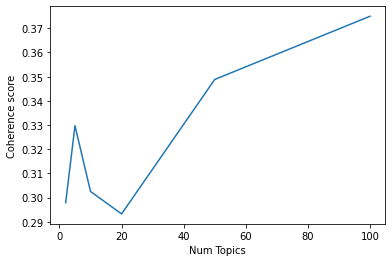

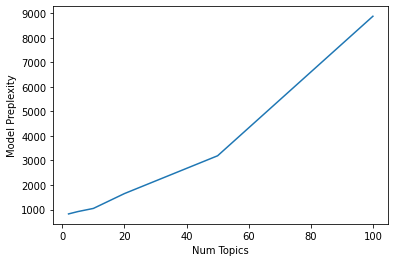

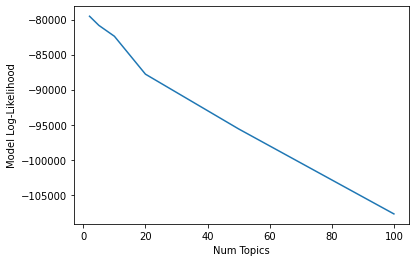

In [58]:
optimized_model, best_coherence = best_model(lemmatized_corpus, 
                                             bow_corpus, dictionary, 
                                             n_topics_range = [2, 5, 10, 20, 50, 100])

In [59]:
best_coherence

0.3749913941681766